In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

**Extract Data**

In [0]:
path=untar_data(URLs.MNIST)
print(path)

/root/.fastai/data/mnist_png


In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
path_training=path/'training'
path_testing=path/'testing'

In [0]:
data=ImageDataBunch.from_folder(path,train='training',valid='testing',ds_tfms=get_transforms(),size=32)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Test: None

**Explore Data**

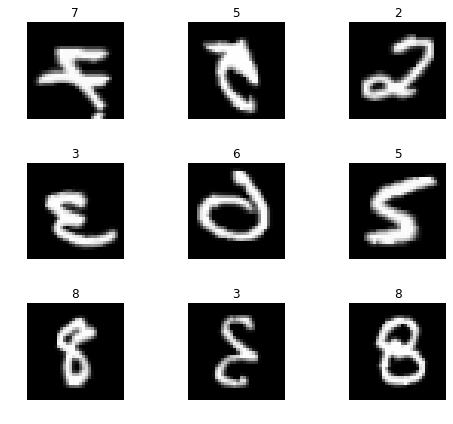

In [0]:
data.show_batch(rows=3,figsize=(7,6))

In [0]:
print('Data Categories: {0}\nNumber of Categories: {1}'.format(data.classes,data.c))

Data Categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of Categories: 10


**Training (Transfer Learning)**

In [0]:
learn_vgg16=create_cnn(data,models.vgg16_bn,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:26<00:00, 21116884.36it/s]


In [0]:
learn_vgg16.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.436954,0.228291,0.075700,02:02
1,0.213199,0.112251,0.037000,02:01
2,0.177149,0.083283,0.027300,02:00
3,0.151088,0.080774,0.027000,02:01


Error_rate(vgg16)=0.027

In [0]:
learn_vgg16.save('vgg16_weights')

**Results**

In [0]:
interp_vgg16=ClassificationInterpretation.from_learner(learn_vgg16)

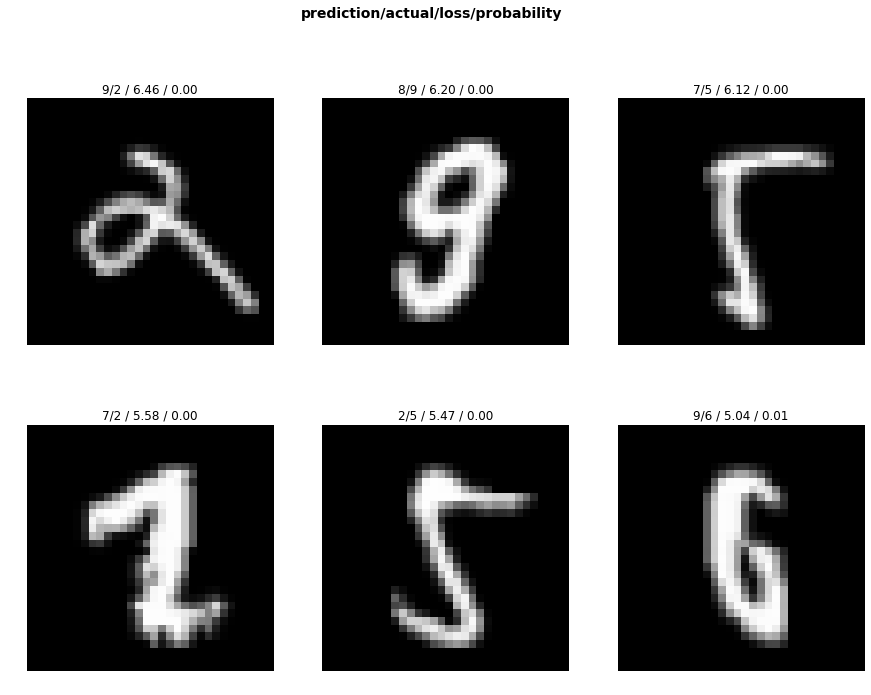

In [0]:
interp_vgg16.plot_top_losses(6,figsize=(15,11))

Here we have plotted the 6 top losses. The loss function is inversely proportional to the accuracy, therefore, the 6 top losses are the 6 datapoints that our model did the worst at predicting their label (Where the model was most confident and missed)

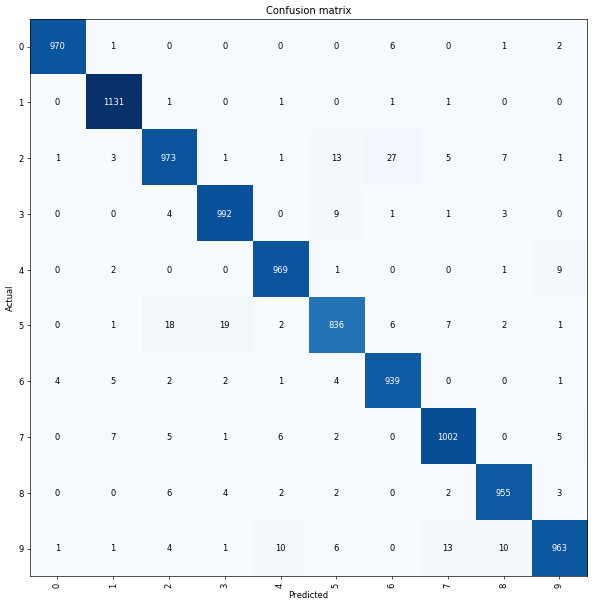

In [0]:
interp_vgg16.plot_confusion_matrix(figsize=(10,10),dpi=60)

The confusion matrix has the predicted category on the x-axis and the actual labels on the y-axis, and each of the corresponding cells contains the number of instances where X and Y has taken a specific value. for instance, if we take the cell on the bottom left, it conveys the following information: we have one instance in which our model has predicted a 0 while the actual label was 9. Consequently, a confusion matrix reflecting a healthy performance would half most of the values concentrated on the diagonal, i.e. predicted = actual.

In [0]:
interp_vgg16.most_confused(min_val=4)

[('2', '6', 27),
 ('5', '3', 19),
 ('5', '2', 18),
 ('2', '5', 13),
 ('9', '7', 13),
 ('9', '4', 10),
 ('9', '8', 10),
 ('3', '5', 9),
 ('4', '9', 9),
 ('2', '8', 7),
 ('5', '7', 7),
 ('7', '1', 7),
 ('0', '6', 6),
 ('5', '6', 6),
 ('7', '4', 6),
 ('8', '2', 6),
 ('9', '5', 6),
 ('2', '7', 5),
 ('6', '1', 5),
 ('7', '2', 5),
 ('7', '9', 5),
 ('3', '2', 4),
 ('6', '0', 4),
 ('6', '5', 4),
 ('8', '3', 4),
 ('9', '2', 4)]

We can see here that the instance where our model is most confused about is the 2, prediciting it to be a 6 27 times.

Actual --> 2
Prediction --> 6

**Fine-Tuning**

In [0]:
learn_vgg16.unfreeze()

In [0]:
learn_vgg16.load('vgg16_weights')

Learner(data=ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
4,4,4,4,4
Path: /root/.fastai/data/mnist_png;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


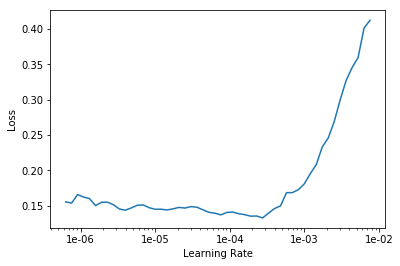

In [0]:
learn_vgg16.lr_find()
learn_vgg16.recorder.plot()

We can see that the loss function becomes unstable after the learning rate takes the value 1e-04, therefore we'll set it as the upper limit of the learning rate slice (the learning rate in which we'll train the last layers of ConvNet)

In [0]:
learn_vgg16.unfreeze()

Train for two epochs using the new learning rate slice obtained from the lr_find plot.

In [0]:
learn_vgg16.fit_one_cycle(2,max_lr=slice(1e-06,1e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.115823,0.055403,0.019100,02:09
1,0.085778,0.049688,0.017300,02:09


We can clearly see an improvement on the error_rate dropping from 0.027 to 0.0173 after a little tweak of the learning rate.

**RESNET34**

Let us check the performance of the ResNet34 architecture in terms of time and error_rate compared to the VGG16 architecture, reiterating the same process.

In [0]:
learn_ResNet=create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 114880525.23it/s]


In [0]:
learn_ResNet.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.732196,0.392989,0.126900,02:15
1,0.342256,0.166933,0.052500,02:15
2,0.243516,0.118780,0.037500,02:16
3,0.232723,0.113222,0.037500,02:16


We can see that after 4 epochs the error_rate is 0.0375, and the average time taken/epoch is 2:15, therefore the VGG16 architecture is superior to the ResNet34 in both accuracy and training time. Let's see if changing the learning rate would fix that.

In [0]:
learn_ResNet.save('ResNet_weights')

In [0]:
learn_ResNet.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


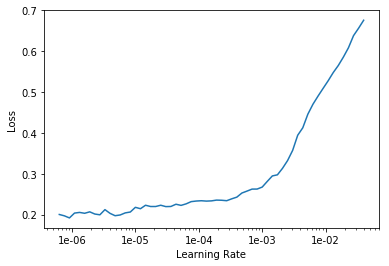

In [0]:
learn_ResNet.lr_find()
learn_ResNet.recorder.plot()

In [0]:
learn_ResNet.fit_one_cycle(2,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.201407,0.083504,0.026700,02:29
1,0.158704,0.071632,0.022500,02:28


We can see that the VGG16 prediction accuracy is still superior to the ResNet even after tweaking the value of the learning rate.

**One Last experiment**
Let's check the difference between the functions fit and the fit_one_cycle in performance.

In [0]:
learn_vgg16_2=create_cnn(data,models.vgg16_bn,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [0]:
learn_vgg16_2.fit(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.265685,0.149066,0.048800,02:00
1,0.192271,0.097920,0.031900,02:00
2,0.153433,0.076894,0.024800,02:01
3,0.141655,0.063526,0.021100,02:02


Surprisingly, the fit function has produced better accuracy that the fit_one_cycle, considering that the latter is state of the art!

**Conclusion**

It is concluded that the performance of our classifier is primarly affected by our choice of hyperparameters:
  1)Model's Architecture (Tested)
  2)Batch Size (To be tested)
  3)Learninng Rate (Tested)
  4)Training method (Tested)
  5)Quantity of data (To be tested)
  5)Quality of data,e.g. different data augmentation techniques (To be tested)
  6)Number of epochs (Tested)